### Импорт библиотек 

In [43]:
# для автоматизации действий веб-браузера
from selenium import webdriver
from selenium.webdriver.common.by import By
# для работы с многомерными массивами
import numpy as np
# для работы с даннными и таблицами
import pandas as pd
# настраивать время в запросах
import time
# В библиотеке sklearn содержится наиболее оптмаильный метод для вычисления линейной регрессии
from sklearn.linear_model import LinearRegression 
# для постоения графиков
import matplotlib.pyplot as plt
# для создания нейронной сети
import tensorflow as tf

# Парсинг 

In [44]:

def smart_waiter(driver, interval=0.5, max_attempts=20, by=By.TAG_NAME, value='body'):
    time.sleep(2)

    #todo более умное ожидание не 2 сек
    '''
    for _ in range(max_attempts):
        try:
            element = driver.find_element(by, value)
            return
        except NoSuchElementException:
            pass
        sleep(interval)
    print("Время ожидания превышено. Страница не загружена.")
    '''

def get_page_html(url):
    driver = uc.Chrome()
    try:
        driver.get(url)
        smart_waiter(driver)
        html = driver.page_source
        
        return html

    finally:
        driver.quit()

def get_powernet_data():
    driver = webdriver.Chrome()

    driver.get("https://www.powernet.com.ru/channels-stat")

    smart_waiter(driver)
    
    names = [p.text for p in driver.find_elements(By.XPATH, "//table/tbody/tr/td[2]")]
    num1 = [p.text for p in driver.find_elements(By.XPATH, "//table/tbody/tr/td[4]")]
    num2 = [p.text for p in driver.find_elements(By.XPATH, "//table/tbody/tr/td[6]")]

    driver.quit()

    data = []
    for i in range(len(names)):
        data.append([names[i].lower(), float(num1[i][:-2].replace("<","")), float(num2[i][:-2].replace("<",""))])
        #Телеканал, Рейтинг по времени просмотра, Рейтинг по количеству зрителей

    return data


def get_mediascope_data():
    driver = webdriver.Chrome()

    driver.get("https://mediascope.net/data/")

    smart_waiter(driver)

    people_input1 = driver.find_element(By.XPATH, '//*[@id="rates_form"]/div/div[3]/div[2]/div/div[1]')
    people_input1.click()

    time.sleep(0.5)

    people_input2 = driver.find_element(By.XPATH, '//*[@id="rates_form"]/div/div[3]/div[2]/div/div[2]/div/div[2]')
    people_input2.click()

    time.sleep(0.5)

    button = element = driver.find_element(By.XPATH, '//*[@id="rates_form"]/div/div[7]/div/input[1]')
    button.click()

    time.sleep(0.5)

    program_names = [p.text for p in driver.find_elements(By.XPATH, "//table/tbody/tr/td[3]")]
    names = [p.text for p in driver.find_elements(By.XPATH, "//table/tbody/tr/td[6]")]
    num1 = [p.text for p in driver.find_elements(By.XPATH, "//table/tbody/tr/td[7]")]
    num2 = [p.text for p in driver.find_elements(By.XPATH, "//table/tbody/tr/td[8]")]
    num3 = [p.text for p in driver.find_elements(By.XPATH, "//table/tbody/tr/td[9]")]
    driver.quit()

    data = []
    for i in range(len(names)):
        data += [[names[i].lower(),program_names[i].lower(), float(num1[i]), float(num2[i]), float(num3[i])]]
        #Телеканал, Программа, Рейтинг, Доля, Охват

    return data




### Сохраняем данные 

In [45]:
# сохраняем спарсенные данные в массивы

ans1 = get_powernet_data()

ans2 = get_mediascope_data()


### Сохраняем данные в csv таблицу

In [46]:

newframeOfAns1 = pd.DataFrame(ans1)
newframeOfAns1.to_csv(f'csv_export_train.csv',index=False)
newframeOfAns2 = pd.DataFrame(ans2)
newframeOfAns2.to_csv(f'csv_export_train.csv',index=False)

### Формируем датасет

In [47]:
train_data = []
train_labels = []

for i in range(7):

    frame1 = pd.read_csv(f'csv_export_train{i + 1}.csv').to_numpy()
    frame2 = pd.read_csv(f'csv_export_mediascope{i + 1}.csv').to_numpy()

    for i in range(len(frame1)):
        for j in range(len(frame2)):
            if (frame1[i][0] == frame2[j][0]):
                frame1[i][0] = i
                frame2[j][0] = i
                train_data.append(frame1[i])
                train_labels.append(frame2[j])
                
#print(len(train_data))
#print(len(train_labels))

Создадим класс Channel, при помощи которого удобно хранить и систематизировать данные

In [48]:
class Channel:
    def __init__(self, channel_id, view_rating, audience_rating):
        self.channel_id = channel_id
        self.view_rating = view_rating
        self.audience_rating = audience_rating


# Линейная регрессия

Линейная регрессия - самый простой инструмент выявления зависимости между различными числовыми признакми. Часто линейную регрессию относят к методам машинного обучения, однако на самом деле - это не так. Восстановить линейную ргрессию - то есть линейную зависимость между различными числовыми данными - можно с помощью аналитического решения. Тем не менее, так как линейная ргрессия решает ту же задачу, что и машинное обучение - задачу восстановления зависимости между данными - для регрессии применяются те же термины и понятия, что и для машинного обучения.

### Машинное обучение

Центральным понятием машинного обучения является _обучающая выборка_. Это примеры, на основе которых планируется строить общую закономерность. Она обозначается $X$ и состоит из $l$ пар объектов $x_{i}$ и известных ответов $y_{i}$:

$$X = (x_{i}, y_{i})^l_{i=1}.$$

Функция, отображающая пространство объектов $\mathbb{X}$ в пространство ответов $\mathbb{Y}$, позволяющая делать предсказания, называется _алгоритмом_ или _моделью_ и обозначается $a(x)$. Она принимает на вход объект и выдает ответ.

Отметим, что $ x_{i} = (x^{1}, x^{2}, ..., x^{d}) $. То есть каждый объект $x_{i}$ состоит из ряда различных значений.

#### Функционал ошибки

Для обучения модели и сравнения различных моделей между собой необходимо разработать математическую формулу и алгоритм расчёта ошибки модели. В рамках решения задачи оптимизации обычно ставится задача достижения минимального значения функционала ошибки.

В качестве очевидного решения можно предложить такую формулу:
$Q(a,y)=a(x)-y$. Однако, у неё есть принципиальная проблема: у такой функции не существует минимума.

С учётом этого, логичным кажется решение использовать в качестве функции для расчёта ошибки модуль отклонения $Q(a,y)=|a(x)-y|$. Соответствующий функционал ошибки называется средним абсолютным отклонением (mean absolute error, MAE):

$$Q(a,x) = \frac{1}{l}\sum^{l}_{i=1}|a(x_{i})-y_{i}|.$$

Однако, мы уже разбирали, что функционал ошибки или функция потерь, должны быть дифференцируемы, а значит, необходимо предложить другой вариант базовой функции для расчёта ошибки: $Q(a,y)=(a(x)-y)^{2}$. Такая функция является гладкой и имеет производную в каждой точке, а ее минимум достигается при равенстве истинного ответа $y$ и прогноза $a(x)$.

Основанный на этой функции функционал ошибки называется _среднеквадратичным отклонением_ (mean squared error, MSE):

$$Q(a,x) = \frac{1}{l}\sum^{l}_{i=1}(a(x_{i})-y_{i})^{2}.$$

#### Вывод аналитической формулы для решения линейной регрессии

Таким образом, задача расчёт оптимальных коэффициентов математически может быть записана следующим образом.

$$Q(w,x) = \frac{1}{l}\sum^{l}_{i=1}(\left \langle w,x_{i} \right \rangle-y_{i})^{2} \rightarrow \underset{w}{\text{min}}.$$

Если вас смущает возникшая, казалось бы путаница, между различными записями, то целесообразно ввести матричную запись признаков:

$$X = \begin{pmatrix}
x_{11} & ... & x_{1d}\\
... & ... & ...\\
x_{l1} & ... & x_{ld}
\end{pmatrix},$$

$$y = \begin{pmatrix}
y_{1}\\
...\\
y_{l}
\end{pmatrix}.$$

Таким образом, задача начинает выглядеть следующим образом

$$Q(w, X) = \frac{1}{l}||Xw-y||^{2}\rightarrow \underset{w}{\text{min}},$$

Взяв производную (от матрицы (!)) и прировняв её к нулю (точка экструма квадратинчной функции) можно получить значения коэффициентов:

$$w = (X^{T}X)^{-1}X^{T}y.$$


In [19]:
# данные для примера 

x = np.array([-2,-2,-1,0,-1,1,2]).reshape((-1, 1))
y = np.array([9, 4, 1, 0, 1, 4, 9])

In [20]:
# Создаем модель линейной регрессии - т.е. прямой которая будет проходить через наши точки
# Эта операция создаёт переменную model в качестве экземпляра LinearRegression

model = LinearRegression()


In [21]:
# С помощью метода fit() применяем нашу модель к нашему набору данных - обучем модель
# С помощью .fit() вычисляются оптимальные значение весов w₀ и w₁ и т.д,
# используя существующие вход и выход (x и y) в качестве аргументов.

model.fit(x, y)

LinearRegression()

In [22]:
y_pred = model.predict(x)

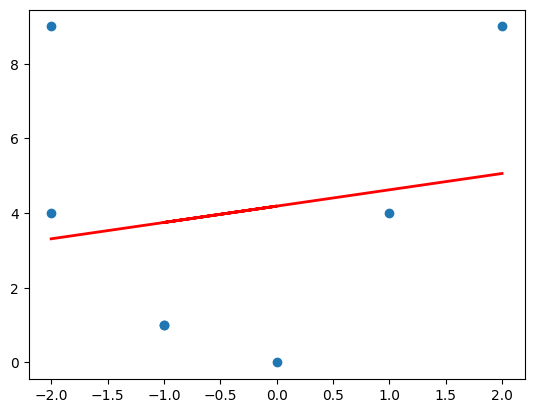

In [23]:

plt.scatter(x, y)
plt.plot(x, y_pred, color='red', linewidth=2)
plt.show()

На простом примере мы убедились, что линейная регрессия не точный вариант предсказания, тк при наличие квадратичной и другой зависимости мы получим неточный результат. Таким образом для решения данной задачи больше подходит нейронная сеть. Перейдём к её описанию.

# Нейронная сеть


1. **Характер данных**: 
   В задаче у вас есть параметры такие как название телеканала (train_data) :  мы присвоим каждому уникальный channel_id, рейтинг по времени просмотра (view_rating) и рейтинг по количеству зрителей (audience_rating) которые мы успешно спарсили с сайта. Также есть другой набор данных (train_labels) с параметрами как название телеканала (channel_id), программа (programm_id), рейтинг (rating) и охват (coverage). 
   
2. **Тип нейронной сети**:
   Для работы с подобного рода структурированными данными, подходит нейронная сеть с архитектурой, способной обрабатывать входные параметры различной природы и типа.
   Можно использовать комбинацию различных слоев нейронной сети, таких как:

   (1)Плотные слои (Dense layers*) для обработки числовых значений рейтингов просмотров.
   *Полносвязные слои (Dense):
   После извлечения признаков в сверточных слоях, данные передаются в полносвязные слои,
   которые обрабатывают все признаки одновременно и делают окончательные прогнозы.
   Количество нейронов в последних полносвязных слоях соответствует количеству классов для классификации.

   (2)Сверточные слои (Convolutional layers) для работы с текстовыми данными (названия телеканалов, программы).

   (3)Объединение этих слоев для создания модели способной извлекать различные признаки из данных и предсказывать рейтинг телеканала.
   
3. **Обоснование выбора**:
   Выбор комбинации плотных слоев обусловлен тем, что плотные слои могут хорошо работать с числовыми данными,
   Такие типы слоев смогут обрабатывать разные типы входных данных и их комбинация поможет создать модель способную решать задачу предсказания рейтинга телеканала.

4. **Анализ ошибок**:
   Ошибки могут возникать из-за несоответствия данных, недостаточного количества обучающих примеров, неправильного выбора архитектуры нейронной сети, неправильно настроенных гиперпараметров и других факторов.
   Важно проводить анализ ошибок после обучения модели, чтобы понять, какие аспекты работы нейронной сети требуют доработки.

In [49]:


class NeuralNetwork:
    def __init__(self):
        self.model = tf.keras.Sequential([
            tf.keras.layers.Dense(64, activation='relu', input_shape=(2,)),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(1)
        ])
        self.model.compile(optimizer='adam', loss='mean_squared_error')

    def predict(self, channel):
        inputs = tf.constant([[channel.view_rating, channel.audience_rating]])
        output = self.model.predict(inputs)
        return output

    def train(self, train_data, train_labels, epochs=100):
        X_train = tf.constant([[data[1], data[2]] for data in train_data])
        y_train = tf.constant([[label[2]] for label in train_labels])
        history = self.model.fit(X_train, y_train, epochs=epochs, verbose=0)
        self.plot_training_results(history)

    def calculate_deviation(self, validation_data):
        X_val = tf.constant([[data[1], data[2]] for data in validation_data])
        y_val = tf.constant([[data[2]] for data in validation_data])

        predictions = self.model.predict(X_val)
        deviation = self.calculate_mse(y_val, predictions)
        return deviation

    def calculate_mse(self, y_true, y_pred):
        return tf.reduce_mean(tf.square(y_true - y_pred))

    def plot_training_results(self, history):
        loss = history.history['loss']
        epochs = range(1, len(loss) + 1)
        plt.plot(epochs, loss, 'b', label='Training loss')
        plt.title('Training loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

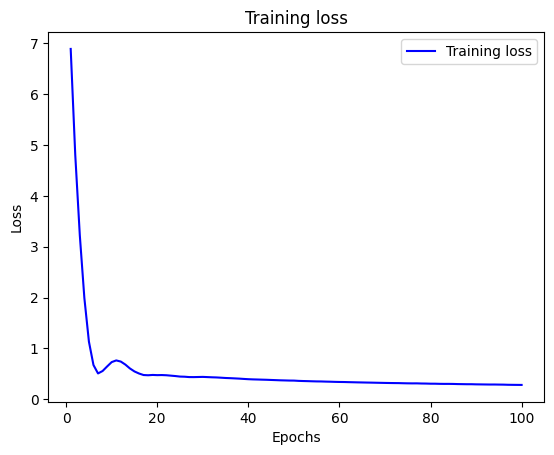

1/1 [==============================] - 0s 30ms/step
[[2.4197483]]


"\n# Расчет отклонения на validation_data\nvalidation_data = [[1, 8.5, 1], [2, 7.3, 1]]  # данные для валидации\ndeviation = neural_network.calculate_deviation(validation_data)\nprint(f'Mean Squared Error: {deviation.numpy()}')\n"

In [50]:
# Каналы для предсказания
channel = Channel(1, 8.07, 3.82)


# Создание экземпляра нейронной сети
neural_network = NeuralNetwork()

# Обучение нейронной сети

"""
train_data = [[1, 8.5, 1], [2, 7.3, 1]]  # примеры данных для обучения
train_labels = [[1, 'TV1', 8.7, 0.4, 0.8], [2, 'TV2', 7.0, 0.3, 0.6]]  # метки для обучения
"""

neural_network.train(train_data, train_labels, epochs=100)

# Предсказание рейтингов для каналов
print(neural_network.predict(channel))

"""
# Расчет отклонения на validation_data
validation_data = [[1, 8.5, 1], [2, 7.3, 1]]  # данные для валидации
deviation = neural_network.calculate_deviation(validation_data)
print(f'Mean Squared Error: {deviation.numpy()}')
"""

График training loss наглядно демонстрирует результат 